In [2]:
import matplotlib.pyplot as plt
import numpy as np
import rebound as rb
import reboundx as rbx
%matplotlib inline

In [3]:
init_params=[]
init_params.append({'m': 0.0008, 'rho': 1.04534352444679,'a':0.275,'e':0.01,'inc':0 
                    }) #,'omega':np.deg2rad(176.839),'Omega':np.deg2rad(351.238),'M':np.deg2rad(251.503)})
init_params.append({'m':0.00254,'rho':1.04534352444679,'a': 0.5,'e': 0.01, 'inc':0
                   }) #,'omega': np.deg2rad(157.419),'Omega': np.deg2rad(207.477),'M':np.deg2rad(210.452)})
init_params.append({'m':5e-05,'rho':1.04534352444679,'a':0.9 ,'e':0.01,'inc':0 
                   }) #,'omega':np.deg2rad(99.629),'Omega':np.deg2rad(257.996),'M':np.deg2rad(343.739)})

In [4]:
def mod_2pi(ang):
    """ Mod an angle to be between 0 and 2*pi"""
    try:
        for i,p in enumerate(ang):
            while p < 0:
                p += 2*np.pi
            while p > 2*np.pi:
                p -= 2*np.pi
            ang[i] = p
    except TypeError:
        while ang < 0:
            ang += 2*np.pi
        while ang > 2*np.pi:
            ang-= 2*np.pi
           
    return ang

def mod_pi(ang):
    """ Mod an angle that's between -pi and pi to 0 to 2*pi"""
    try:
        for i,p in enumerate(ang):
            while p < -np.pi:
                p += 2*np.pi
            while p > np.pi:
                p -= 2*np.pi
            ang[i] = p
    except TypeError:
        while ang < -np.pi:
            ang += 2*np.pi
        while ang > np.pi:
            ang-= 2*np.pi
           
    return ang

def calc_timescale(t,tau,t0):
    temp = 1 - .5*(1 + np.tanh( (t - t0)/tau))
    if temp < 1e-8:
        return np.infty
    else:
        return 1/temp

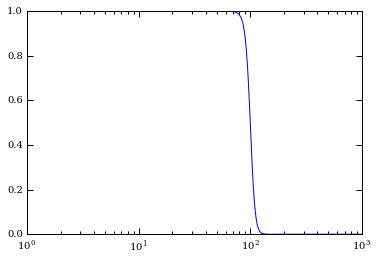

In [5]:
t=np.linspace(0,1000.,1000)
plt.semilogx(t,(1-.5*(1+np.tanh((t-100)/10))))

In [6]:
class Results():
    def __init__(self,times=np.linspace(0,100.,100),npart=3,fromfile=None):
        if fromfile is not None:
            self.read_state(fromfile)
        else:
            self.times = times
            self.npart = npart
            self.megno = np.zeros(times.shape)
            self.lyap = np.zeros(times.shape)
            self.energy = np.zeros(times.shape)
            self.avals = np.zeros((len(times),npart))
            self.avalsf = np.zeros((len(times),npart))
            self.evals = np.zeros((len(times),npart))
            self.ivals = np.zeros((len(times),npart))
            self.pvals = np.zeros((len(times),npart))
            self.lapvals = np.zeros(times.shape)
            self.dtvals = np.zeros(times.shape)
            self.tend=times[-1]
            self.stage_one_time = np.infty
            self.stage_two_time = np.infty
    def update(self,sim,i,chaos=True):
        ps = sim.particles
        self.avals[i,:] = [p.a for p in ps[1:]]
        self.evals[i,:] = [p.e for p in ps[1:]]
        self.ivals[i,:] = [p.inc for p in ps[1:]]
        self.pvals[i,:] = [p.P for p in ps[1:]]
        self.lapvals[i] = mod_2pi(ps[1].l - 3*ps[2].l + 2*ps[3].l)
        if chaos:
            self.megno[i] = sim.calculate_megno()
            self.lyap[i] = sim.calculate_lyapunov()
        
        self.energy[i] = sim.calculate_energy()
        self.dtvals[i] = sim.dt
        return
    def plot(self,fname=None):
        fig,axes=plt.subplots(7,1,sharex=True,figsize=(10,15))
        axa = axes[0]
        axe = axes[1]
        axl = axes[2]
        axE = axes[3]
        axmeg = axes[4]
        axper = axes[5]
        axdt = axes[6]

        ind = self.times<self.tend


        axa.plot(self.times[ind],self.avals[ind,0],'-b',
                 self.times[ind],self.avals[ind,1],'-g',
                 self.times[ind],self.avals[ind,2],'-r')
        
        axe.plot(self.times[ind],self.evals[ind,0],'-b',
                 self.times[ind],self.evals[ind,1],'-g',
                 self.times[ind],self.evals[ind,2],'-r')
        
        #xl.plot(self.times[ind],np.rad2deg(np.abs(self.lapvals[ind]-np.pi)))
        axl.plot(self.times[ind],mod_pi(self.lapvals[ind]))

        axE.plot(self.times[ind],abs((self.energy-self.energy[0])/self.energy[0])[ind])
        #axmeg.plot(times[ind],megno[ind])
        #axmeg.plot(times[ind],1/lyap[ind])
        axmeg.plot(self.times, ( 1/self.lyap )) #/self.sim.tau_e)
        axper.plot(self.times[ind],self.pvals[ind,2]/self.pvals[ind,1],'-b',label='$P_3/P_2$')
        axper.plot(self.times[ind],self.pvals[ind,1]/self.pvals[ind,0],'-g', label='$P_2/P_1$')
        axper.plot(self.times[ind],self.pvals[ind,2]/self.pvals[ind,0],'-r',label='$P_3/P_1$')
        axa.set_ylabel('a')
        axe.set_ylabel('e')
        axl.set_ylabel('$|\\phi_{Laplace}|$')
        axE.set_ylabel('$\\Delta E / E$')
        axper.set_ylabel('$P_2/P_1$')
        axmeg.set_ylabel('$\\tau_{lyap}/\\tau_e$ (yrs)')
        axes[-1].set_xlabel('t (yrs)')
        axper.legend(loc='upper right')
        axper.axhline(4,color='k')
        axper.axhline(2,color='k')

        axdt.plot(self.times[ind],self.dtvals[ind])
        axdt.plot(self.times[ind], self.pvals[ind,0] * (1-self.evals[ind,0])**(1.5) / 10,'--k',linewidth=3)
        axdt.set_ylabel('$\\Delta t$')
        #axes[2].set_yscale('log')
        #axes[0].set_ylim(0,1)
        #axes[4].set_ylim(1,3)
        for ax in axes:
            ax.minorticks_on()
            if self.stage_one_time < self.tend:
                ax.axvline(self.stage_one_time,color='k',linewidth=3)
            if self.stage_two_time < self.tend:
                ax.axvline(self.stage_two_time,color='k',linestyle='-',linewidth=3)
        #axes[0].set_xscale('log')
        if fname is not None:
            fig.savefig(fname)
        return
    
    def plot_laplace(self):
        if self.times[-1] < self.stage_two_time:
            print 'Simulation never got past stage two!'
            return
        ind2 = (self.times<=self.tend)&(self.times>self.stage_two_time)
        t2 = self.times[ind2]
        #vals = np.abs(self.lapvals[ind2]-np.pi)
        vals = mod_pi(self.lapvals[ind2])
        lp_mean =np.array([vals[t2<=x].mean() for x in t2])
        lp_std = np.array([vals[t2<=x].std() for x in t2])

        e3 = self.evals[ind2,2]
        e_mean =  np.array([ e3[t2<=x].mean() for x in t2 ])
        e_std = np.array([e3[t2<=x].std() for x in t2 ])

        e2 = self.evals[ind2,1]
        e2_mean =  np.array([ e2[t2<=x].mean() for x in t2 ])
        e2_std = np.array([e2[t2<=x].std() for x in t2 ])
        


        fig,axes=plt.subplots(3,1,figsize=(10,4),sharex=True)
        axes[0].plot(t2-t2[0],vals,'-b',alpha=.6)
        axes[0].plot(t2-t2[0],lp_mean,'-k',linewidth=3)
        axes[0].fill_between(t2-t2[0],lp_mean-lp_std,lp_mean+lp_std,color='r',alpha=.3)
        axes[1].plot(t2-t2[0],e3,'-b',alpha=.6)
        axes[1].plot(t2-t2[0],e_mean,'-k',linewidth=3)
        axes[1].fill_between(t2-t2[0],e_mean-e_std,e_mean+e_std,color='r',alpha=.3)
        axes[1].plot(t2-t2[0],e2,'-g',alpha=.6)
        axes[1].plot(t2-t2[0],e2_mean,'--k',linewidth=3)
        axes[1].fill_between(t2-t2[0],e2_mean-e2_std,e2_mean+e2_std,color='m',alpha=.6)
       
        axes[2].plot(t2-t2[0],1./self.lyap[ind2],'-b')
    
        axes[0].set_ylabel('$\\phi$',fontsize=20)
        axes[1].set_ylabel('$e$',fontsize=20)
        axes[2].set_xlabel('$t - t_0$',fontsize=20)
        axes[2].set_ylabel('$\\tau_l$',fontsize=20)
        plt.subplots_adjust(hspace=0)
        axes[2].set_yscale('log')
        for ax in axes:
            ax.minorticks_on()
    def save_state(self,fname='results.dat'):
        
        with open(fname,'wb') as f:
            np.array([float(len(self.times)),float(self.npart)]).tofile(f)
            self.times.tofile(f)
            self.megno.tofile(f)
            self.lyap.tofile(f)
            self.energy.tofile(f)
            self.avals.tofile(f)
            self.avalsf.tofile(f)
            self.evals.tofile(f)
            self.ivals.tofile(f)
            self.pvals.tofile(f)
            self.lapvals.tofile(f)
            self.dtvals.tofile(f)
            np.array([self.tend]).tofile(f)
            np.array([self.stage_one_time]).tofile(f)
            np.array([self.stage_two_time]).tofile(f)
        return   
    def read_state(self,fname='results.dat'):
        dat = np.fromfile(fname)
        nt,npart = dat[:2]
        npart = int(npart)
        nt = int(nt)
        self.npart = npart
        
        dat = dat[2:]
        self.times = dat[:nt]
        dat = dat[nt:]
        self.megno = dat[:nt]
        dat = dat[nt:]
        self.lyap = dat[:nt]
        dat = dat[nt:]
        self.energy = dat[:nt]
        dat = dat[nt:]
        self.avals = dat[:nt*npart].reshape((nt,npart))
        dat = dat[nt*npart:]
        self.avalsf = dat[:nt*npart].reshape((nt,npart))
        dat = dat[nt*npart:]
        self.evals = dat[:nt*npart].reshape((nt,npart))
        dat = dat[nt*npart:]
        self.ivals = dat[:nt*npart].reshape((nt,npart))
        dat = dat[nt*npart:]
        self.pvals = dat[:nt*npart].reshape((nt,npart))
        dat = dat[nt*npart:]
        
        self.lapvals = dat[:nt]
        dat = dat[nt:]
        self.dtvals = dat[:nt]
        dat = dat[nt:]
        
        self.tend,self.stage_one_time,self.stage_two_time = dat[:3]
        
        return

In [7]:
def set_sim(init_params,dt=.02,integrator='WHFast'):
    sim = rb.Simulation()
    sim.add(m=1.)
    for p in init_params:
            try:
                p.pop('rho')
            except KeyError:
                pass
            sim.add(**p)
    sim.move_to_com()
    sim.integrator = integrator
    ps = sim.particles
    sim.dt = dt #2*np.pi/ps[1].n * (1-ps[1].e)**(1.5) / 10
    sim.exit_max_distance = 5.
    sim.exit_min_distance = 3 * ps[2].a*np.sqrt(ps[2].m/3)

    
    return sim

In [14]:
def stopping_criterion(sim):
    # calculate_orbits() has been run
    ps = sim.particles()
    if ps[-2].n/ps[-1].n <= 2.0:
         if ps[-3].n/ps[-2].n <= 2.0:
                return True
    return False
    
def run_constant_damping(sim,res,times,tau_e=5e2,K=1e2):
    rebx = rbx.Extras(sim)
    params = rebx.add_modify_orbits_direct()

    sim.particles[-1].tau_a = -tau_e * K
    sim.particles[-1].tau_e = -tau_e

    print ps[-1].tau_a, ps[-1].tau_e
  
    run_sim(sim,res,times,chaos=False)
    
    
    return

def run_sim(sim,res,times,chaos=True):
    if chaos:
        sim.init_megno()
    
    for i,t in enumerate(times):
        try:
            sim.integrate(t*2*np.pi,exact_finish_time=0)
        except rb.Escape as error:
            print error
            res.tend = t
            break
        except rb.Encounter as error:
            print error
            res.tend = t
            break
        sim.calculate_orbits()
        res.update(sim,i,chaos=chaos)
        if stopping_criterion(sim):
            res.tend = t
    
    return
            
            


def run_sim(sim,start=0,end=1e6,nt=1e4):
    times = np.linspace(float(start),float(end),nt)
    res = Results(times)
    run_for_time(sim,res,times)
    
    times = res.times[res.times<=res.tend]
    times1 = np.linspace(times[-1],times[-1]+1e3,1e2)
    res1=Results(times1)
    remove_damping(sim,res1,times1)
    
    times1 = res1.times[res1.times<=res1.tend]
    times2 = np.linspace(times1[-1],times1[-1]+1e4,1e3)
    res2=Results(times2)
    run_for_time(sim,res2,times2)
    
    return res,res1,res2,sim

def remove_damping(sim,res,times):
    ps = sim.particles
    tau_e_i = -ps[-1].tau_e
    Ki = abs(ps[-1].tau_a/tau_e_i)
    tot_time = times[-1]-times[0]
    tau = tot_time / 1e2
    t0 = times[0] + tot_time/2.
    tau_e = calc_timescale(times,tau,t0)
     

def run_for_time(sim,res,times)
    ps = sim.particles
    stage_one_complete = False
    stage_two_complete = False
    stage_one_time = 0
    stage_two_time = 0
    res.tend = times[-1]
    

    for i,t in enumerate(times):
        try:
            sim.integrate(t*2*np.pi,exact_finish_time=0)
        except rb.Escape as error:
            print error
            res.tend = t
            break
        except rb.Encounter as error:
            print error
            res.tend = t
            break
        sim.calculate_orbits()
        if not stage_one_complete:
            if ps[-2].n/ps[-1].n <= 2.0:
                print 'Outer pair hit 2:1 resonance at t=%f' % (t*2*np.pi)
                stage_one_complete = True
                res.stage_one_time = t
#            ps[-2].tau_a = ps[-1].tau_a
#            ps[-2].tau_e = ps[-1].tau_e 
#             ps[-1].tau_a = np.infty
#             ps[-1].tau_e = np.infty

        if stage_one_complete and not stage_two_complete:
            if ps[-3].n/ps[-2].n <= 2.0:
                print 'Inner pair hit 2:1 resonance at t=%f' % (t*2*np.pi)
                res.stage_two_time = t
                ps[-1].tau_a = np.infty
                ps[-1].tau_e = np.infty
#            ps[-2].tau_a = np.infty
#            ps[-2].tau_e = np.infty
                stage_two_complete = True
            
#            tend = t
#            break
                sim.init_megno()
        if stage_two_complete:
            tau_e = -ps[-1].tau_e
        
        res.avals[i,:] = [p.a for p in ps[1:]]
        res.evals[i,:] = [p.e for p in ps[1:]]
        res.ivals[i,:] = [p.inc for p in ps[1:]]
        res.pvals[i,:] = [p.P for p in ps[1:]]
        res.lapvals[i] = mod_2pi(ps[1].l - 3*ps[2].l + 2*ps[3].l)
        if stage_two_complete:
            res.megno[i] = sim.calculate_megno()
            res.lyap[i] = sim.calculate_lyapunov()
        
        res.energy[i] = sim.calculate_energy()
        res.dtvals[i] = sim.dt
    ind = times<res.tend
    p3p2 = res.pvals[ind,2][-1]/res.pvals[ind,1][-1]
    p2p1 = res.pvals[ind,1][-1]/res.pvals[ind,0][-1]
    print 'Final time:\t{:.1f}'.format(res.tend)
    print 'Final Planet Ratio:\t{:.1f} : {:.1f} : 1'.format(p3p2*p2p1,p2p1)
    for i in range(len(ps[1:])):
        res.avalsf[:,i] = (res.avals[:,i]-res.avals[0,i])/(res.avals[0,i])

    print 'Final Configuration:'
    for i,p in enumerate(ps[1:],start=1):
        print 'i={:d}\tP={:.3f}\ta={:.3f}\te={:.3f}\ti={:.3f}\tomega={:.3f}\tOmega={:3f}\tM={:3f}'.format(i,p.P,p.a,p.e,np.rad2deg(p.inc),np.rad2deg(p.omega),np.rad2deg(p.Omega),np.rad2deg(p.M))
    
    return res

In [15]:
sim = set_sim(init_params,tau_e=30)

-3000.0 -30.0


In [16]:
res=run_sim(sim,end=1e4,nt=1e3)
#res.plot()

Outer pair hit 2:1 resonance at t=1132.105461
Inner pair hit 2:1 resonance at t=48051.587334
Final time:	10000.0
Final Planet Ratio:	4.1 : 2.0 : 1
Final Configuration:
i=1	P=0.851	a=0.264	e=0.267	i=0.000	omega=175.384	Omega=0.000000	M=-103.240236
i=2	P=1.704	a=0.419	e=0.037	i=0.000	omega=176.230	Omega=0.000000	M=128.097785
i=3	P=3.430	a=0.669	e=0.049	i=0.000	omega=32.469	Omega=0.000000	M=35.502218


/Library/Python/2.7/site-packages/matplotlib/mathtext.py:857: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


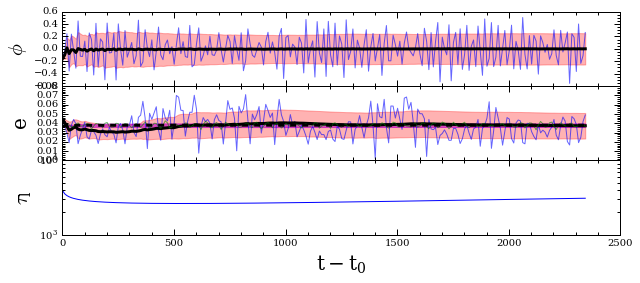

In [11]:
res.plot_laplace()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in divide


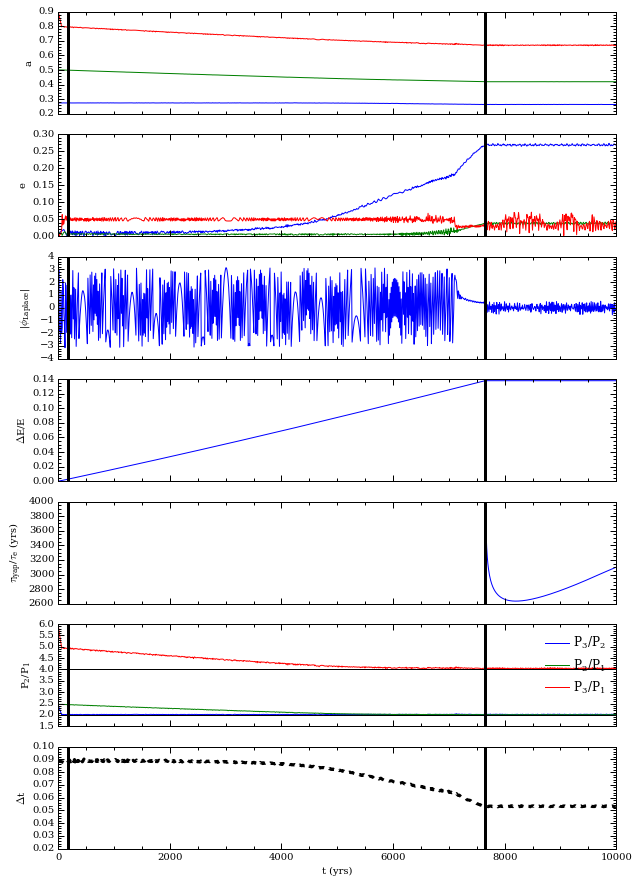

In [12]:
res.plot()

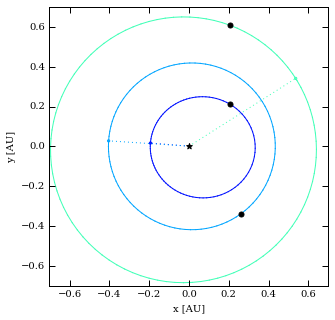

In [13]:
sim.move_to_com()
fig=rb.OrbitPlot(sim,unitlabel='[AU]',color=True,periastron=True)
